# 1. Load Libraries

In [280]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import time

# 2. Load Data

In [281]:
train_x = np.load("train_data.npy")
train_y = np.load("train_label.npy")

test_x = np.load("test_data.npy")
test_y = np.load("test_label.npy")

In [282]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y)

(50000, 128)
(50000, 1)
(10000, 128)
[[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]


# 3. Data Pre-processing

## 3.1. Normalization

In [283]:
train_x_norm = (train_x - np.min(train_x))/(np.max(train_x) - np.min(train_x))
train_y_norm = (train_y - np.min(train_y))/(np.max(train_y) - np.min(train_y))

test_x_norm = (test_x - np.min(test_x))/(np.max(test_x) - np.min(test_x))
test_y_norm = (test_y - np.min(test_y))/(np.max(test_y) - np.min(test_y))

## 3.2. One hot encoding

In [284]:
num_classes = np.unique(train_y_norm).size
        
encoded_train_y = []

for label in train_y_norm:
    encoded_label = np.zeros(num_classes)
    encoded_label[int(label)] = 1
    encoded_train_y.append(encoded_label)

encoded_train_y = np.array(encoded_train_y) 

# 4. Main Classes

## 4.1. Activation Functions

Defines activation functions for the MLP

In [285]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )

    def __relu(self,x):
        return np.maximum(0,x)
  
    def __relu_deriv(self,a):
        return np.heaviside(a, 0)

    def __softmax(self, z):
        z = np.atleast_2d(z)
        max_z = np.max(z, axis=1)
        z = [z[i] - max_z[i] for i in range(max_z.shape[0])] # Numerical Stability
        z = np.array(z)
        return np.divide(np.exp(z).T, np.sum(np.exp(z), axis=1)).T

    def __softmax_deriv(self, y, y_hat):
        return y_hat - y
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu': 
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == "softmax":
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv


## 4.2. Hidden Layers

Defines a typical hidden layer in the MLP

In [286]:
class HiddenLayer(object):    
    def __init__(self,
                 n_in, 
                 n_out,
                 activation_last_layer='relu',
                 activation='relu',
                 W=None, 
                 b=None,
                 output_layer = False,
                 v_W = None,
                 v_b = None):
        """
        A class that defines a typical hidden layer in the MLP: 
        units are fully-connected and have relu activation function. 
        
        Parameters:
        
        Weight matrix W is of shape (n_in,n_out) i.e. (no. of neurons in previous layer, no. of neurons in next layer)
        so when input matrix * weight matrix = (batch size, no. of neurons in next layer)
        and the bias vector b is of shape (n_out,). i.e., the no. of neurons in next layer as we add bias AFTER weight multiplication

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        n_in (int):                         dimensionality of the input into this layer 
        n_out (int):                        dimensionality of the output of this layer, i.e. the number of hidden units/neurons in this layer
        activation (str):                   Activation of the current hidden layer
        activation_last_layer (str):        Activation of the previous layer
        W (array):                          the weight matrix that is multiplied to the input of this layer, shape is (n_in,n_out) 
        b (array):                          the bias matrix that is added to the input of this layer, shape is (n_out, )
        output_layer (boolean):       a boolean to determine if this layer is the final layer of the MLP
        v_W (array):                        v(t) for the weights used in momentum SGD
        v_b (array):                        v(t) for the bias terms used in momentum SGD
        """
        
        # Set class attributes
        self.input=None
        self.activation = Activation(activation).f
        self.activation_deriv_last_layer= None
        self.output_layer = output_layer
        
        if activation_last_layer is not None:
            self.activation_deriv_last_layer=Activation(activation_last_layer).f_deriv # derivative activation for the previous layer in forwards direction; used for backpropagation function below

        # randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )

        # set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # set the size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        self.v_W = np.zeros_like(self.grad_W)
        self.v_b = np.zeros_like(self.grad_b)
        
        # an array with the neurons to be dropped for the current layer (initalized as zeroes but will be changed later on)
        self.dropout_array=np.zeros(n_out)
        
    
    def forward(self, X, prop_dropout):
        '''
        Feedsforward a single hidden layer in the MLP in the training process
        Includes functionality for dropout as a regularization tool

        Parameters:
        X (array): The input data (either the initial data or the output from the previous layer)
        prop_dropout (float): the probability of neurons dropped in the feed-forward process
        
        Returns:
        output: the output of the current layer in MLP
        '''
        
        # Computes the 
        lin_output = np.dot(X, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output))
        
        # Dropout: training the network with only a subset of the neurons
        if not self.output_layer:
            self.dropout_array = np.random.binomial(1, prop_dropout, size = self.output.shape) # creates random array of 0 and 1's, with 0's representing neurons to drop
            self.output = self.dropout_array * self.output

        self.input=X
        return self.output
    

    def forwardtest(self, X, p_dropout):
        '''
        Feedsforward a single hidden layer in the MLP in the test process
        Unlike in fowardpropagation in training, dropout out here is implemented as output scaled down by p_dropout
        
        Parameters:
        X (array): The input data (either the initial data or the output from the previous layer)
        prop_dropout (float): the probability that outputs will be scaled down in feed-forward process
        '''
        
        lin_output = np.dot(X, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        
        # Dropout: scales the outputs of each hidden layer down by prop_dropout during testing
        if not self.output_layer:
            self.output *= p_dropout
        
        self.input=X
        return self.output


    def backward(self, delta, layer_num, output_layer=False):         
        
        """
        Backprogagates a single hidden layer:
        1. Calculates the gradient for this current layer to be used in the update function in the MLP class
        2. Calculates the delta for this current hidden layer and feeds it back to the MLP.backward() function
        3. Includes functionality for dropout for the delta

        Parameters:
        delta (array): delta value of current layer, retrieved from the MLP.backward() and used to calculate the gradient of this layer
        layer_num (int): index of current layer number retrieved from MLP.backward(); index starts from 0
        output_layer (boolean): boolean to determine if the current layer is not the output layer in the MLP
        
        Returns:
        delta (array): delta value of below layer for only the neurons that were not killed off in the forward pass
        """
        
        # gradient for this layer
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.average(delta, axis=0)
        
        # delta for below layer using delta of current layer and derivative of activation of below layer
        if self.activation_deriv_last_layer: # checks if below layer is not input layer
            delta = delta.dot(self.W.T) * self.activation_deriv_last_layer(self.input)

        # Dropout: back propagates the gradients through the neurons that were not killed off during the forward pass
        if (layer_num != 0) and (not self.output_layer):  # layer_num != 0 because the next layer below is input layer
            delta = delta * nn.layers[layer_num-1].dropout_array # layer_num-1 because we want to use the dropout array for the below layer

        return delta

## 4.3. MLP

In [287]:
class MLP:
 
    def __init__(self, layers_neuron_count, activation=[None,'relu', 'relu','relu','softmax'], weight_decay = 0.98):
        """
        Initializes the MLP:
        The code will create all layers automatically based on the provided parameters.

        Parameters:
        layers_neuron_count (list of int):  A list containing the number of units/neurons in each layer.
        activation (list of str):           A list containing the activation function to be used in each layer. Can be "logistic", "tanh", "relu", or "softmax"
        weight_decay (float):               The value to decay the weight in the loss function for regularization
        """        

        # Set class attributes
        self.layers=[] # A list of every layer in the MLP
        self.params=[]
        self.activation = activation
        self.weight_decay = weight_decay

        # Add hidden layers to the MLP one by one
        for i in range(len(layers_neuron_count)-1):
            
            output_layer = False # Flag to signal if the current layer in the loop is final layer
        
            if i == len(layers_neuron_count) -2: # Check if output layer, -1 for input layer, -1 since index is 0
                output_layer = True
            
            self.layers.append(HiddenLayer(layers_neuron_count[i],
                                         layers_neuron_count[i+1],
                                         activation_last_layer=activation[i],
                                         activation=activation[i+1],
                                         output_layer = output_layer))

    def forward(self, X, prop_dropout):
        """
        Feedsforward the input data sequentially through each layer in the MLP in training process:
        In this function, a loop, each layer of the MLP takes the output from the previous layer as input (except the input layer, where it would take the initial data as input) 
        and then performs a calculation on this input to create the output for this layer. 
        This output is then fed as input into the subsequent layer and the calculation is repeated again.
        The exact calculation performed on the input is done throught the HiddenLayer class' forward() method.
        
        Parameters:
        X (array): The initial data that is used as input for the first/input layer in the feedforward process.
        prop_dropout (float): the probability of neurons to be dropped in the feed-forward process
        
        Returns:
        output (array): The final output from the feedforward process after the initial data has passed through all layers in the MLP.
        """

        for layer in self.layers:
            output=layer.forward(X, prop_dropout)
            X=output
        
        return output
    
    def forwardtest(self, X, prop_dropout):
        """
        Feedsforward the input data sequentially through each layer in the MLP in testing:
        In this function, a loop, each layer of the MLP takes the output from the previous layer as input (except the input layer, where it would take the initial data as input) 
        and then performs a calculation on this input to create the output for this layer. 
        This output is then fed as input into the subsequent layer and the calculation is repeated again.
        The exact calculation performed on the input is done throught the HiddenLayer class' forward() method.
        
        Parameters:
        X (array): The initial data that is used as input for the first/input layer in the feedforward process.
        prop_dropout (float): the probability that outputs will be scaled down in feed-forward process
        
        Returns:
        output (array): The final output from the feedforward process after the initial data has passed through all layers in the MLP.
        """

        for layer in self.layers:
            output=layer.forwardtest(X=X, p_dropout=prop_dropout)
            X=output
        
        return output

    def CE_loss(self,y,y_hat):
        """
        1. Calculates the Cross-Entropy( CE) loss 
        Computes the CE loss of all the samples fed through the MLP in the feedforward process, and then computes their average CE loss as we are
        implementing mini-batch training.
        2. Calculates delta of the output layer (which as to have Softmax as activation function) in the MLP so it can be used in the backpropagation process
        
        Parameters:
        y (array):  the actual y values from the dataset
        y_hat ():   the predicted y values using the MLP feedforward process
        
        Returns:
        loss (float):   The average cross-entropy loss for all samples in the mini-batch fed through the MLP in the feedforward process
        output_layer_deltafinal_layer_delta (array):  The delta of the output layer (Softmax activation layer) to be used in the backpropagation process
        """
        
        # CE loss calculation
#         exps = np.exp(y_hat - np.max(y_hat, axis = 1, keepdims = True))
#         last_y_out = exps / np.sum(exps, axis = 1, keepdims = True)
#         error = (last_y_out - y)/ y.shape[0]
#         loss = (-1*np.nansum(y * np.log(y_hat)))/ y.shape[0]
        loss = - np.nansum(y * np.log(y_hat))
        loss = loss / y.shape[0] 
        loss = loss*self.weight_decay

        # Delta of output layer calcualtion
        # Output_layer_delta = error * Activation(self.activation[-1]).f_deriv(y, y_hat)
        output_layer_delta = Activation(self.activation[-1]).f_deriv(y, y_hat)
        
        return loss, output_layer_delta
  
    def backward(self, output_layer_delta):
        """
        The backpropagation process conducted backwards across every layer, starting from the output layer of the MLP:
        Iteratively updates delta for each layer by using the previous layers delta as input to the HiddenLayer.backward() method
        
        Parameters:
        output_layer_delta (array): The calcualted delta for the output layer retrieved from the CE loss function
        """

        # Step 1: backward propagates the output layer of the MLP using output_layer_delta to:
            # 1: find and adds the gradient of output layer as an attribute
            # 2. returns the delta for the final hidden layer of the MLP
        delta = self.layers[-1].backward(output_layer_delta, len(self.layers) -1, output_layer = True) # returns final hidden layer delta
        
        # Step 2: backward propagates the remaining hidden layers (starting from the final hidden layer) through a loop
        # in each iteration:
            # 1. finds and adds the gradient for that hidden layer as an attribute
            # 2. and returns the delta for the next layer below in the MLP which will then be iteratively used as input for calculating the gradient for that respective layer
        for layer_num, layer in reversed(list(enumerate(self.layers[:-1]))):
            delta = layer.backward(delta, layer_num)

    
    def update(self,lr,optimization):
        """
        NOTE: run this function AFTER MLP.backward() has been run
        Updates the weights and bias of every layer in the MLP according to Stochastic Gradient Descent (SGD) (i.e. according to the delta's calculated in the backward process)
        Includes functionality to optimize SGD via Momentum and regularize the model via Weight decay 
        
        Parameters:
        lr (float):                         Learning rate for the parameter updates
        optimization (dict of str: float):  A dictionary with the key as the type of optimization (functionality will be provided only for 1 key: "Momentum"), and values of the key are the parameter values for that optimization method
        """
        
        if optimization is None:
            for layer in self.layers:
                layer.W -= lr * layer.grad_W
                layer.b -= lr * layer.grad_b
        else:
            for layer in self.layers:
                layer.v_W = (optimization['Momentum'] * layer.v_W) + (lr * layer.grad_W)
                layer.v_b = (optimization['Momentum'] * layer.v_b) + (lr * layer.grad_b)
                layer.W = (layer.W - layer.v_W)*self.weight_decay
                layer.b = layer.b - layer.v_b

  
    # it will return all losses within the whole training process.
    def fit(self,X,y,learning_rate=0.1, epochs=100, optimization = {"Momentum":0.9}, batch_size = 1, prop_dropout=None):
        """
        Trains the MLP with mini-batches:
        Iterates through epochs; In each epoch, the entire dataset is trained in batches, with each batch being fed forward to learn the loss (and delta)
        and then backpropagated to update the weights and bias of the MLP
        
        Parameters: 
        X (array):                          Input data or features
        y (array):                          Input targets
        learning_rate (float):              parameters defining the speed of learning
        epochs (int):                       number of times the dataset is presented to the network for learning
        optimization (dict of str: float):  A dictionary with the key as the type of optimization (functionality will be provided only for 1 key: "Momentum"), and values of the key are the parameter values for that optimization method
        batch_size (int):                   the number of samples in each batch to be used in mini-batch leraning
        prop_dropout (float):               probability of dropout 
        
        Returns:
        to_return (list):                   A list of Cross Entropy loss for each epoch
        """ 
        
        X=np.array(X)
        y=np.array(y)
        
        # no. of batches in an epoch/no. of iterations in an epoch
        num_batches = int(np.ceil(X.shape[0]/batch_size)) 
        
        to_return = np.zeros(epochs)
        training_accuracy = []
        
        for k in range(epochs):
            epoch_start_time = time.time()
            
            loss = np.zeros(num_batches) 
            current_index = 0 

            #Shuffle the data to ensure that each epoch will have different sequence of observations
            shuffled_index = np.arange(X.shape[0])
            np.random.shuffle(shuffled_index)
            X = X[shuffled_index]
            y = y[shuffled_index]

            for batch_index in range(num_batches):
                #forward pass 
                y_hat = self.forward(X[current_index : current_index + batch_size, ],prop_dropout=prop_dropout)

                #backward pass
                loss[batch_index], delta = self.CE_loss(y[current_index : current_index + batch_size], y_hat)
                self.backward(delta)

                #update
                self.update(learning_rate, optimization)

                #Update the index based on the batch window for the next batch in mini-batch learning
                if (current_index + batch_size) > X.shape[0]:
                    batch_size = X.shape[0] - current_index
                current_index += batch_size
            
            to_return[k] = np.mean(loss)
            
            # training loss for this epoch
            train_predict = self.predict(x=X, prop_dropout=prop_dropout)
            ## Decode one-hot encoded labels back to class labels by finding index of maxmax value in the one-hot encoded array
            decoded_predictions = np.zeros(train_predict.shape[0])
            for prediction_idx, prediction_vector in enumerate(train_predict):
                decoded_predictions[prediction_idx] = int(np.argmax(prediction_vector)) 
            train_predict = decoded_predictions
            #train_accuracy = np.sum(train_predict ==  test_y_norm[:, 0]) / train_predict.shape[0]
            #training_accuracy.append(train_accuracy)
            
            epoch_end_time = time.time()
            epoch_time = epoch_end_time - epoch_start_time
            
            
            
            print("Epoch {}/{} | Loss {:.7f} | used {:.2f} seconds".format(str(k+1), str(epochs), to_return[k],epoch_time))
            print("------------------------------------------------------------")
        
        return to_return

    
    def predict(self, x, prop_dropout):
        """
        Predict results of new data in testing using an already trained network
        
        Parameters:
        x (array): input x data in which the MLP will use to make predictions
        
        Returns:
        predictions (array): the predictions from test data using the trained network
        """
        x = np.array(x)
        predictions = [i for i in range(x.shape[0])]
        
        # feeds forward each sample in test set through the MLP to retrieve prediction
        for i in np.arange(x.shape[0]):
            predictions[i] = self.forwardtest(X=x[i,] , prop_dropout= prop_dropout)

        predictions = np.array(predictions)
        return predictions
    
    

# 5. Hyperparameters

In [288]:
# MLP
LAYERS_NEURON_COUNT = [train_x_norm.shape[1],120,100,50,10]
LAYER_ACTIVATION_FUNCS = [None,'relu', 'relu','relu','softmax']
WEIGHT_DECAY = 0.98

# Fitting
LEARNING_RATE = 0.01
EPOCHS = 10
OPTIM = {"Momentum":0.9} # or None
BATCH_SIZE = 100
DROPOUT_PROB = 0.5 # or None

# 6. Training

In [289]:
# Instantiate the MLP

nn = MLP(layers_neuron_count = LAYERS_NEURON_COUNT, 
         activation=LAYER_ACTIVATION_FUNCS,
         weight_decay = WEIGHT_DECAY)

In [290]:
# Fitting data to MLP

import time

start = time.time()
CE = nn.fit(X = train_x_norm,
           y = encoded_train_y,
           learning_rate = LEARNING_RATE,
           epochs = EPOCHS,
           optimization = OPTIM,
           batch_size = BATCH_SIZE,
           prop_dropout = DROPOUT_PROB)

end = time.time()


print("TIME USED TO TRAIN ENTIRE DATASET IN {} EPOCHS:".format(EPOCHS))
time_total = end - start
if time_total > 60:
    time_min = time_total // 60
    time_min = int(time_min)
    time_sec = time_total % 60
else:
    time_min = 0
    time_sec = time_total

if time_min > 1:
    print("{} minutes {:.2f} seconds".format(time_min, time_sec))
else:
    print("{} minute {:.2f} seconds".format(time_min, time_sec))

Epoch 1/10 | Loss 0.4089659 | used 3.16 seconds
------------------------------------------------------------
Epoch 2/10 | Loss 0.3447671 | used 3.03 seconds
------------------------------------------------------------
Epoch 3/10 | Loss 0.3416325 | used 3.00 seconds
------------------------------------------------------------
Epoch 4/10 | Loss 0.3412093 | used 3.18 seconds
------------------------------------------------------------
Epoch 5/10 | Loss 0.3424224 | used 3.04 seconds
------------------------------------------------------------
Epoch 6/10 | Loss 0.3387690 | used 2.98 seconds
------------------------------------------------------------
Epoch 7/10 | Loss 0.3384406 | used 3.06 seconds
------------------------------------------------------------
Epoch 8/10 | Loss 0.3370427 | used 2.97 seconds
------------------------------------------------------------
Epoch 9/10 | Loss 0.3364465 | used 3.11 seconds
------------------------------------------------------------
Epoch 10/10 | Loss 

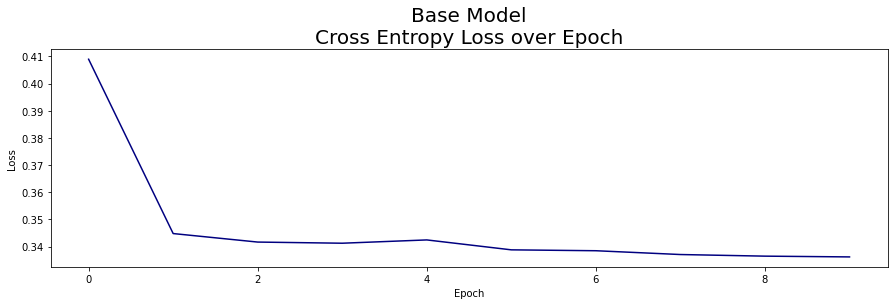

In [291]:
# Visualizing Training Loss over Epoch

pl.figure(figsize=(15,4))
pl.title('Base Model\nCross Entropy Loss over Epoch', fontsize=20) 
pl.plot(CE, color="navy")
pl.ylabel('Loss')
pl.xlabel('Epoch')
pl.show()


In [ ]:
# Visualizing Training accuracy over Epoch

# Decode one-hot encoded y_hat labels back to class labels


# 7. Testing

In [274]:
predictions = nn.predict(x=test_x_norm, prop_dropout=DROPOUT_PROB)

print(predictions)
    
decoded_predictions = np.zeros(predictions.shape[0])
for prediction_idx, prediction_vector in enumerate(predictions):
    decoded_predictions[prediction_idx] = int(np.argmax(prediction_vector)) 

print(decoded_predictions)

[0. 0. 0. ... 0. 0. 0.]


0.0


/var/folders/y5/qwxzs1_d0qv0lbbz056t7mlc0000gn/T/ipykernel_1231/3960293885.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.sum(predictions ==  test_y_norm[:, 0]) / predictions.shape[0]


# 8. Evaluation